# Исследовательский хакатон Яндекс Практикума

### Отрасль и направления деятельности:
EdTech, сервис онлайн-образования.

### Общее описание задачи:
провести исследование по теме наставничества и менторства на основании контента социальной сети Linkedin, размещенного в открытом доступе, созданного целевой аудиторией.

### Цели исследования:
   * Определить топ-10 тем в направлении наставничества на основании наибольшего охвата, используя теги Наставничество, менторство, коучинг, mentorship, mentor, coaching, buddy.
   * Определить топ-10 популярных тем по просмотрам, реакциям: лайкам, комментариям, репостам среди IT-специалистов, подходящих под описание целевой аудитории исследования.
   * Дополнить профили целевой аудитории новыми параметрами.
   
### Стратегия:
Ввиду сложности получения поисковой выдачи одновременно и по целевой аудитории и по наличию у них постов про менторство нами была выбрана стратегия поиска аккаунтов сотрудников работающих в интересных нам доменах и должностях, с последующим сбором и анализом их постов.

## Подготовка

Загрузим библиотеки и объявим константы.

In [1]:
import json
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import spacy
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm

Скачаем модель для модуля spacy.

In [ ]:
!python -m spacy download ru_core_news_sm -q

# EDA

Выбранная стратегия предполагает два отдельных парсинга - сначала ссылки на аккаунты, потом хождение по ним и сбор постов.

И хотя матрица для сбора предполагала что пулчится напарсить около 36 * 100 * 10 (~36000) аккаунтов, из-за ограничения по времени и медленного сбора самих постов мы решили ограничится только частью.

Посмотрим на результат парсинга профилей.

In [ ]:
links = pd.read_csv('../data/02_intermediate/clean_links.csv')
print('Общее количество ссылок на аккаунты:', len(links))
fig = px.histogram(links, x='search_keywords', title='Распределение по ролям и грейдам для ссылок')
fig.show()

Вторым этапом было хождение по ссылкам профилей и поиск самих постов.

Загрузим и осмотрим данные.

In [4]:
df = pd.read_csv('../data/02_intermediate/clean_posts.csv')
df.head()

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
0,https://www.linkedin.com/in/varvara-kulmeteva-...,senior web developer,Varvara Kulmeteva,Senior Web Developer - IBS InfinitySoft,IBS,Навыки: ReactJS · JavaScript · HTML · CSSНавык...,10.0,"Москва, Московская область, Россия",0.0,NaN,NaN,NaN,NaN
1,https://www.linkedin.com/in/rauventa,senior frontend,Ilya Moiseenko,"LOOKING FOR ""Senior/Lead Frontend (React) Deve...",Centicore,"Ilya, React Developer from Moscow.Ilya, React ...",8.0,"Москва, Москва, Россия",1.0,Я только что получил(а) значок за навык «JavaS...,1.0,NaN,NaN
2,https://www.linkedin.com/in/denis-kuchkildin,middle data analyst,Denis Kuchkildin,Data Analyst at X5 Group,X5 Group,I have a strong engineering background and mor...,6.0,"Москва, Москва, Россия",1.0,Hi everyone - I am looking for a new role and ...,NaN,NaN,NaN
3,https://www.linkedin.com/in/ACoAAC4yJzEB4TjXkJ...,senior ML engineer,Ian Silantev,MSc Data Science in University of East London ...,Neurospot,"Absolutely in love with Data Science, AI and M...",2.0,"Тбилиси, Грузия",0.0,NaN,NaN,NaN,NaN
4,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9.0,Finding a job for trainees and juniors is a ch...,1.0,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14459 entries, 0 to 14458
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   account_link     14459 non-null  object 
 1   search_keywords  3856 non-null   object 
 2   name             5489 non-null   object 
 3   title            14421 non-null  object 
 4   works_at         3853 non-null   object 
 5   intro            3816 non-null   object 
 6   experience       3809 non-null   float64
 7   place            3811 non-null   object 
 8   posts_cnt        4161 non-null   float64
 9   post_text        12980 non-null  object 
 10  reaction_cnt     11791 non-null  object 
 11  comments_cnt     10616 non-null  float64
 12  repost_cnt       10225 non-null  float64
dtypes: float64(4), object(9)
memory usage: 1.4+ MB


Всего в датасете 14459 постов. Для каждого есть ссылка на аккаунт (account_link), для некоторых постов есть данные по поисковым запросам, имя участника, должность, место работы, описание из раздела "О себе", суммарный опыт работы, местоположение, общее количество постов у данного участника, текст конкретного поста, количество реакций, комментариев и репостов для данного поста.

Многие поля заполняются на сайте пользователем в свободной форме, поэтому сложны для анализа. Например, посмотрим на количество уникальных должностей.

In [6]:
len(df['title'].unique())

1548

1548 при общем количестве 14421, т.е. в среднем по 10 человек на один тип должности. При необходимости можно почистить эти записи и проанализировать, однако в данном случае нас больше интересуют посты людей.

Для дальнейшего анализа и работы сбросим строки без постов, категорийные Nan'ы заменим на надпись 'unknown', количественные в оценках постов на 0, проверим на дубликаты.

In [7]:
df = df[df['post_text'] != 'нет постов']
df = df[~df['post_text'].isnull()]

Избавимся от пропусков.

In [8]:
df['search_keywords'].fillna(value='unknown', inplace=True)
df['name'].fillna(value='unknown', inplace=True)
df['title'].fillna(value='unknown', inplace=True)
df['works_at'].fillna(value='unknown', inplace=True)
df['intro'].fillna(value='unknown', inplace=True)
df['place'].fillna(value='unknown', inplace=True)

In [9]:
df['experience'].fillna(value=0, inplace=True)
df = df[df['experience'] <= 50]

Т.к. количество постов ранее могло быть неверным (при неполном прохождении по странице или если бот не смог найти кнопку раскрытия следующих постов, но при этом при дублировании ссылок в следующий раз проходил полностью), то следует пересчитать фактическое количество постов.

In [10]:
df.drop_duplicates(subset=['account_link', 'post_text', 'reaction_cnt', 'comments_cnt', 'repost_cnt'], inplace=True)

In [11]:
post_count = df.pivot_table(index=['account_link'], values=['post_text'], aggfunc='count')
post_count.rename(columns={'post_text': 'posts_cnt'}, inplace=True)
post_count.reset_index(inplace=True)

In [12]:
df.drop(columns='posts_cnt', inplace=True, errors='ignore')
df = df.merge(post_count, how='left', on='account_link', sort=False)

Осталось заполнить нулями пропуски в реакциях.

In [13]:
df['reaction_cnt'].fillna(value=0, inplace=True)
df['comments_cnt'].fillna(value=0, inplace=True)
df['repost_cnt'].fillna(value=0, inplace=True)

Также можно обратить внимание что в одном из датасетов лайки были собраны как текст. Надо преобразовать к интам.

In [14]:
df['reaction_cnt'] = df['reaction_cnt'].apply(lambda x: re.sub(r' |,', '', str(x)))

Теперь преобразуем типы.

In [15]:
df['experience'] = df['experience'].astype('int')
df['reaction_cnt'] = df['reaction_cnt'].astype('float').astype('int')
df['comments_cnt'] = df['comments_cnt'].astype('int')
df['repost_cnt'] = df['repost_cnt'].astype('int')
df['posts_cnt'] = df['posts_cnt'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12523 entries, 0 to 12522
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   account_link     12523 non-null  object
 1   search_keywords  12523 non-null  object
 2   name             12523 non-null  object
 3   title            12523 non-null  object
 4   works_at         12523 non-null  object
 5   intro            12523 non-null  object
 6   experience       12523 non-null  int32 
 7   place            12523 non-null  object
 8   post_text        12523 non-null  object
 9   reaction_cnt     12523 non-null  int32 
 10  comments_cnt     12523 non-null  int32 
 11  repost_cnt       12523 non-null  int32 
 12  posts_cnt        12523 non-null  int32 
dtypes: int32(5), object(8)
memory usage: 1.1+ MB


Также, из набора данных придётся удалить вручную тексты на украинском и белорусском языках, т.к. при лемматизации они засорят словарь, а автоматически отфильтровать их проблематично из-за большого количества похожих с русским букв.

In [16]:
df = df[df['place'] != 'Киев, Киев, Украина']
df.reset_index(drop=True, inplace=True)

to_filter = ['також', 'дуже', 'якщо', 'допомогти', 'вакансії', 'штучний', 'життя', 'які', 'своїм', 'що']
texts = df['post_text'].tolist()
counter = 0
to_remove = []
for text in texts:
    if [i for i in to_filter if i in text]:
        to_remove.append(counter)
    counter += 1
    
df.drop(index=to_remove, inplace=True)
df.reset_index(drop=True, inplace=True)

Обработка почти закончена, посмотрим на распределения.

In [ ]:
fig = px.histogram(
    df[df['search_keywords'] != 'unknown'], x='search_keywords',
    title='Распределение по ролям и грейдам для страниц'
)
fig.show()

К сожалению, из-за ограничений по времени выборка получилась разношёрстной.

Посмотрим в каких компаниях работаю люди, которые оставляют посты на своих страницах.

In [ ]:
data = df.drop_duplicates(subset=['account_link'])
data = data[data['works_at'] != 'unknown']
data = data.pivot_table(index=['works_at'], values=['account_link'], aggfunc='count')
data.reset_index(inplace=True)
data.loc[data['account_link'] < 3, 'works_at'] = 'Other companies'
fig = px.pie(data, values='account_link', names='works_at', title='Крупнейшие работодатели')
fig.show()

Даже без чистки столбца видно что самые популярные работодатели это Яндекс, Сбербанк и Тинькофф.

Посмотрим на распределение по опыту.

In [ ]:
data = df.drop_duplicates(subset=['account_link'])
fig = px.histogram(data[data['experience'] != 0], x='experience', title='Распределение по стажу')
fig.show()

Средний опыт работы осматриваемой аудитории составляет 6-7 лет.

Посмотрим на распределение количества постов.

In [ ]:
data = df.drop_duplicates(subset=['account_link'])
data = data[data['posts_cnt'] < 50]
fig = px.histogram(data[data['experience'] != 0], x='posts_cnt', title='Распределение по количеству постов')
fig.show()

### Выводы

Мы смогли собрать ссылки на 11338 акаунтов, но только с ~ 2200 из них успели собрать посты (~ 1400). Тем не менее, после добавления аккаунтов от других команд и чистки у нас получилось 12523 текстовых комментариев от 982 аккаунтов.

Наиболее популярные работодатели это Яндекс, Сбербанк и Тинькофф.

Средний опыт аудитории - 6-7 лет.

Чаще всего встречается 1-2 поста на профиль.

Перерейдём к топик-моделированию.

# Моделирование

В качестве модели для топик-моделирования будем использовать модель **LDA** (Латентное размещение Дирихле) из модуля Scikit-Learn, для лемматизации - библиотеку **spacy** с моделью *ru_core_news_sm*, для векторизации - **Tf-Idf**.

## Подготовка текстов

Теперь выполним токенизацию и лемматизацию текстов с помощью *ru_core_news_sm*.

In [21]:
model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

Складываем все новости в один список

In [22]:
texts = df['post_text'].tolist()

Выполняем лемматизацию текстов.

In [23]:
%%time
res = []
for doc in model.pipe(texts, disable=["tagger", "parser"]):
    res.append([token.lemma_ for token in doc])

CPU times: total: 3min 33s
Wall time: 3min 33s




Удалим знаки препинания, цифры и слова, содержащие цифры. Для это соберём регулярное выражение, которое подходит для любого слова, состоящего из букв кирилицы.



In [24]:
pattern = re.compile("^[а-яА-ЯёЁ]*$")
def remove_symbols(doc):
    return [token for token in doc if pattern.match(token)]
corpus = list(map(remove_symbols, res))

Теперь необходимо провести векторизацию. Воспользуемся Tf-Idf. Также добавим исключения для стоп-слов.

In [25]:
stop_words = stopwords.words('russian')
new_stopwords = [
    'иб', 'це', 'ми', 'ваш', 'наш', 'що', 'это',
    'свой', 'вже', 'як', 'щоб', 'ти', 'чи'
]
stop_words.extend(new_stopwords)

Для векторизации используем отбираем слова, минимальное количество постов в которых они встречаются равным 3 и не более чем в 95% текстов.

In [26]:
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=3, max_df=0.95)

TfIdfVectorizer принимает на вход список предложений, поэтому необходимо объединить списки слов, составляющих корпус, в предложения.

In [27]:
docs = [" ".join(tokens) for tokens in corpus]

In [28]:
x = tfidf.fit_transform(docs)

In [29]:
x.shape

(12362, 6444)

In [30]:
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names())}

## Определение количества тем

Метод кластеризации K-means обладает интересной особенностью, для него есть метод определения оптимального количества кластеров - "метод локтя". Он заключается в итеративном нахождении инерции (сумма квадратов дистанций от образца до центра кластера) и вычерчивания графика количество_кластеров - инерция. Излом на графике показывает оптимальное количество кластеров.

In [31]:
%%time
inertia = []
for k in tqdm(range(1, 20), 'progress'):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=31416, n_init=100).fit(x)
    inertia.append(np.sqrt(kmeans.inertia_))

progress: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.02s/it]

CPU times: total: 37.2 s
Wall time: 19.3 s


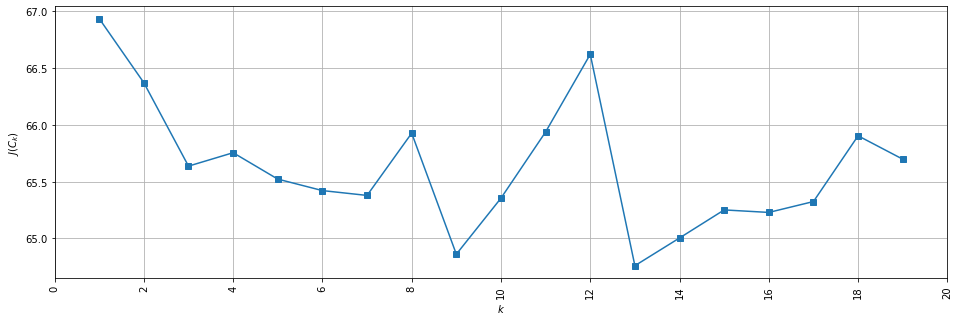

In [32]:
fig = plt.figure(figsize=(16, 5))
plt.plot(range(1, 20), inertia[:19], marker="s")
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.xticks(np.arange(0, 21, 2), rotation=90)
plt.grid()
plt.show()

Видно что график имеет наименьшую инерцию на 13 кластерах.

## Топик-моделинг с LDA

Теперь можем запустить алгоритм LDA. Зададим количество тем равное 13.

In [33]:
n_topics = 13

In [34]:
lda = LatentDirichletAllocation(n_components=n_topics, random_state=31416)

In [35]:
topics = lda.fit_transform(x)

In [36]:
topics.shape

(12362, 13)

Получили массив размера *x13. Строки здесь - отдельные тексты, а колонки - 13 выделенных тем. В каждой ячейке стоит вероятность того, что данный текст относится к данной теме.

### Ключевые слова

Теперь извлечём ключевые слова для каждой из 13 тем. Пройдёмся по каждой из 13 выделенных тем и для каждой возьмём ТОП-20 слов.

По очереди пройдёмся по каждой теме (первое измерение массиа) и выберем ТОП-20 слов, наиболее характерных для этой темы. Потом по индексу слова обратимся к словарю и узнаем, что это за слово.

In [37]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]][::-1]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
удовольствие, сообщать, начинать, должность, компания, новый, работа, шпаргалка, тестировщиков, разработчик, тестировщика, тестер, тестировщик, скрам, слайд, ведущий, сон, уч, вебдизайн, заведение

 
Тема 2 :
отзыв, благодарность, лендинг, делать, хороший, благодарю, новость, результат, скидка, командный, работа, саме, команда, доступ, тренинг, уметь, отличный, докладчик, содержательный, поздравить

 
Тема 3 :
работа, команда, компания, проект, опыт, год, весь, мочь, человек, очень, новый, работать, интересный, ещё, искать, разработка, время, хороший, нужный, вакансия

 
Тема 4 :
вакансия, супер, мем, логотип, процессов, берлин, спб, покупатель, спасибо, подавать, мимо, виртуальный, разработать, продакт, нам, лс, гипотеза, июль, тр, дизайн

 
Тема 5 :
навык, значок, проверка, тест, хотеть, следующий, пройти, разработка, приложение, услуга, консалтинг, статья, радость, бизнес, просмотреть, оказывать, сообщать, услуги, новый, запустить

 
Тема 6 :
кибербезопасность, инфобез, оче

### Типичные статьи

Теперь для каждой темы возьмём по три документа, которые хорошо соответсвуют этой теме. Для этого заглянем в массив _topics_.

In [38]:
for i in range(n_topics):
    doc_ids = np.argsort(topics[:, i])[::-1][:3]
    print("Тема ", i + 1)
    for doc_id in doc_ids:
        print(df.iloc[doc_id]["post_text"])
        print('-' * 50)
    print("\n")

Тема  1
 'С удовольствием сообщаю, что я начинаю работу в новой должности\xa0– Старший разработчик программного обеспечения в компании Перспективный мониторинг!']
--------------------------------------------------
С удовольствием сообщаю, что я начинаю работу в новой должности – Ведущий программист в компании Сейлз-хаус «Газпром-Медиа»!
--------------------------------------------------
С удовольствием сообщаю, что я начинаю работу в новой должности – Senior ML Engineer в компании SberDevices, где буду заниматься обучением больших мультимодальных и мультиязычных моделей!
--------------------------------------------------


Тема  2
Наконец сменил обстановку для работы. Жаль, что временно. НУ, а пока... солнце, Ереван и очень много вкусной еды 😌
--------------------------------------------------
"Кривой угол", продолжение про 7 красных перпендикулярных линий. Хорошо бы снять ролик про собеседование Андерсена
--------------------------------------------------
Полевые испытания присадки IF

### Распределение постов по темам

Посмотрим как распределились посты по темам.

In [ ]:
count = [np.argmax(a) + 1 for a in topics]
fig = px.histogram(count, title='Распределение постов по темам', log_y=True,
                   labels = dict(value='порядковый номер темы'))
fig.update_layout(xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1))
fig.update_layout(bargap=0.2)
fig.update_layout(showlegend=False)
fig.show()

Распределение тем по количеству постов:

1. объявления о выходе на работу (тема 1)
2. посты в стиле блога на отвлечённые темы (тема 3)
3. объявления о поиске новой работы (тема 8)
4. юмор (тема 6)
5. оказание различных услуг (тема 5)
6. посты про различные места (тема 2)
7. объявления о найме сотрудников (тема 10)
8. ретроспективные отзывы о текущем месте работы (тема 12)
9. объявления о разработке на заказ (тема 11)
10. обзоры событий за неделю (тема 7)

### Топик-моделинг популярных постов

Для начала посмотрим на распределение реакций, лайков и репостов среди постов.

In [40]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
experience,12362.0,1.325028,3.404101,0.0,0.0,0.0,0.0,36.0
reaction_cnt,12362.0,520.097557,11048.845650,0.0,1.0,3.0,10.0,622839.0
comments_cnt,12362.0,6.930836,50.050701,0.0,0.0,0.0,1.0,967.0
repost_cnt,12362.0,7.141806,50.842806,0.0,0.0,0.0,1.0,979.0
posts_cnt,12362.0,35.119641,34.435926,1.0,16.0,31.0,37.0,219.0


In [ ]:
data = df.query('reaction_cnt < 200 & comments_cnt < 200 & repost_cnt < 200')
fig = px.histogram(
    data, x=['reaction_cnt', 'comments_cnt', 'repost_cnt'],
    title='Распределение количества реакций, лайков и репостов по постам', log_y=True
)
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)
fig.show()

В связи с тем что небольшое количество англоязычных постов содержат сотни тысяч реакций, средние значения оказались сильно завышены. При этом абсолютное большинство постов имеют 200 и менее реакций. Т.к. количество информации у нас ограничено, примем за "популярные" те посты в которых более какой-либо реакции больше 10.

In [42]:
data = df.query('reaction_cnt >= 10 | comments_cnt >= 10 | repost_cnt >= 10')
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
experience,3149.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
reaction_cnt,3149.0,2033.997142,21823.695867,0.0,14.0,23.0,61.0,622839.0
comments_cnt,3149.0,25.791680,96.712166,0.0,0.0,1.0,6.0,967.0
repost_cnt,3149.0,26.724039,98.130620,0.0,0.0,1.0,5.0,979.0
posts_cnt,3149.0,30.638615,12.706749,1.0,27.0,32.0,35.0,122.0


Мы сократили количество записей в четыре раза, посмотрим как это отразилось на темах.

Избавимся от тех постов которые не вошли в топ.

In [43]:
best_index = np.where((df['reaction_cnt'] >= 10) | (df['comments_cnt'] >= 10) | (df['repost_cnt'] >= 10))
best_topics = topics[best_index[0]]

Посмотрим на типичные популярные посты по каждой из тем.

In [44]:
for i in range(n_topics):
    doc_ids = np.argsort(best_topics[:, i])[::-1][:3]
    print("Тема ", i + 1)
    for doc_id in doc_ids:
        print(df.iloc[doc_id]["post_text"])
        print('-' * 50)
    print("\n")

Тема  1
Поговорим о важности Бренда!Иногда бренд это лишь торговая марка.Но в нашем случае, Бренд - это Имя!Имя, которое говорит само за себя. Имя, которому доверяют.Доверяют те, кто знает цену и ценность Имени.А также знают как сложно его сохранить.Мы гордимся своим Именем и теми, кто его ценит также высоко, как свое собственное!С большой благодарностью к вашему доверию.СимбирСофт.
--------------------------------------------------
Hello everyone! I want to share with you a link with an analysis of the complexity of operations in Python. Everyone who uses Python should know this.https://lnkd.in/ekQyZ7tK
--------------------------------------------------
Всем привет!)Решила сменить место работы, поэтому сейчас в активном поиске.Готова рассмотреть предложения как на позицию рекрутера, так и на позицию hr.В профиле информация актуальная.Люблю свою работу и свое направление)Немного обо мне:6 лет работаю в IT-РекрутингеЗанимаюсь подбором специалистов в IT,Digital и Блокчейн сфере.Адаптацие

Также посмотрим как изменилось распределение по темам по сравнению с общим набором постов.

In [ ]:
import plotly.graph_objects as go

count = [np.argmax(a) + 1 for a in topics]
count_best = [np.argmax(a) + 1 for a in best_topics]

fig = go.Figure()
fig.add_trace(go.Histogram(x=count, bingroup=1, name='все посты'))
fig.add_trace(go.Histogram(x=count_best, bingroup=1, name='популярные посты'))
fig.update_layout(
    xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1), bargap=0.2, barmode='overlay',
    title='Распределение постов по темам', xaxis_title='порядковый номер темы', yaxis_title='количество постов'
)
fig.update_traces(opacity=0.5)
fig.update_yaxes(type="log")

Распределение тем по количеству популярных постов несколько изменилось:

Первая тройка осталась без изменений:

1. объявления о выходе на работу (тема 1)
2. посты в стиле блога на отвлечённые темы (тема 3)
3. объявления о поиске новой работы (тема 8)

Дальше места несколько изменились.

4. объявления о найме сотрудников (тема 10 поднялась на 3 пункта) 
5. юмор (тема 6 опустилась на 1 пункт)
6. объявления о разработке на заказ (тема 11 поднялась на 3 пункта)
7. ретроспективные отзывы о текущем месте работы (тема 12 поднялась на 1 пункт)
8. анонсы статей (тема 4 с 11 места)
9. рекламные анонсы (тема 9 с 13 места)
10. посты про различные места (тема 2 опустилась на 4 пункта)

Темы "обзоры событий за неделю", "оказание различных услуг", "различные объявления" в топ не попали.

## Заключение

Мы провели исследование по теме наставничества и менторства на основании контента социальной сети Linkedin, размещенного в открытом доступе, созданного целевой аудиторией.

В ходе данной работы мы:

   * Создали парсер для ссылок на аккаунты выделенной ЦА.
   
   
   * Создали парсер информации по ЦА и созданных ей постов.
   
   
   * Очистили и подготовили данные.
   
   
   * **Определили топ-10 тем  в направлении наставничества на основании наибольшего охвата**:
   
     * 1. объявления о выходе на работу (тема 1)
     * 2. посты в стиле блога на отвлечённые темы (тема 3)
     * 3. объявления о поиске новой работы (тема 8)
     * 4. юмор (тема 6)
     * 5. оказание различных услуг (тема 5)
     * 6. посты про различные места (тема 2)
     * 7. объявления о найме сотрудников (тема 10)
     * 8. ретроспективные отзывы о текущем месте работы (тема 12)
     * 9. объявления о разработке на заказ (тема 11)
     * 10. обзоры событий за неделю (тема 7)
     
     
   * **Определили топ-10 популярных тем по просмотрам, реакциям: лайкам, комментариям, репостам среди IT-специалистов, подходящих под описание целевой аудитории исследования**:
   
    * Первая тройка осталась без изменений:
      * 1. объявления о выходе на работу (тема 1)
      * 2. посты в стиле блога на отвлечённые темы (тема 3)
      * 3. объявления о поиске новой работы (тема 8)
    * Дальше места несколько изменились.
      * 4. объявления о найме сотрудников (тема 10 поднялась на 3 пункта) 
      * 5. юмор (тема 6 опустилась на 1 пункт)
      * 6. объявления о разработке на заказ (тема 11 поднялась на 3 пункта)
      * 7. ретроспективные отзывы о текущем месте работы (тема 12 поднялась на 1 пункт)
      * 8. анонсы статей (тема 4 с 11 места)
      * 9. рекламные анонсы (тема 9 с 13 места)
      * 10. посты про различные места (тема 2 опустилась на 4 пункта)
    * Темы "обзоры событий за неделю", "оказание различных услуг", "различные объявления" в топ не попали.
    
    
   * **В качестве дополнения профиля целевой аудитории можно предложить требование активной публичной деятельности, т.е. наличие значительного количества постов, т.к. активно постящие люди испытывают потребность делиться своим опытом и получать внимание окружающих, что может быть использовано в качестве мотивирующей части при попытке завлечь человека в наставничество.**

В качестве улучшений для данной работы можно предложить более строгие условия для поиска изначальных ссылок, а также опробовать стратегию с поиском самих постов по ключевым словам и уже из них отсеивать искомых нам специалистов.